In [1]:
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
import fusion
import time
import numpy as np
import tensorflow as tf

mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['lines.color'] = 'r'

In [2]:
data = []
with open("gyro.dat",'r') as f:
        for line in f:
            result = re.findall(r"-?\d+.\d+", line)
            if len(result) == 10:
                data.append([float(x) for x in result])

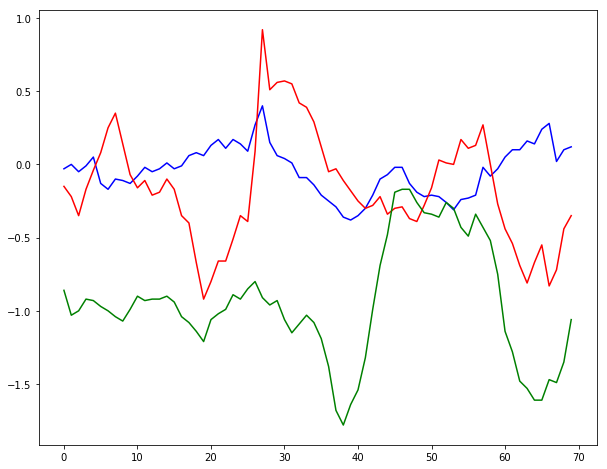

In [3]:
plt.plot([x[1] for x in data], color='b')
plt.plot([x[2] for x in data], color='r')
plt.plot([x[3] for x in data], color='g')
plt.show()

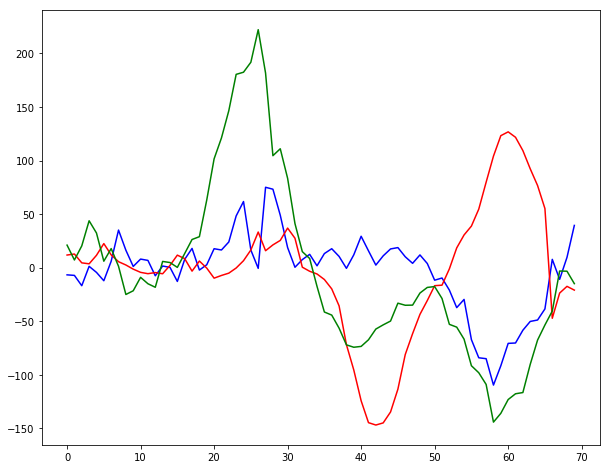

In [4]:
plt.plot([x[4] for x in data], color='b')
plt.plot([x[5] for x in data], color='r')
plt.plot([x[6] for x in data], color='g')
plt.show()

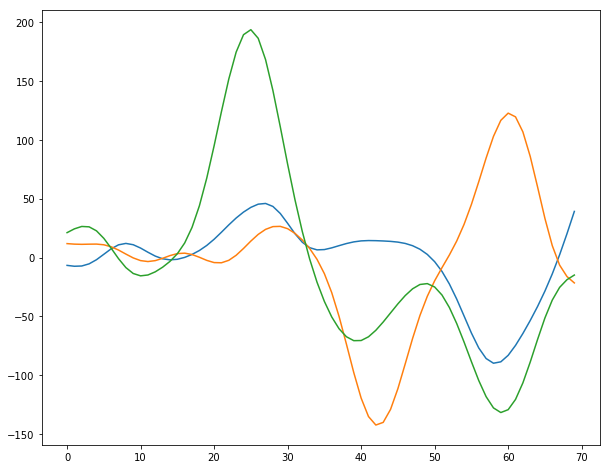

In [5]:
smooth_a = np.array(3, )
for i in range(4, 7):
        x = [x[i] for x in data]
        b, a = signal.butter(3, 0.2)
        y = signal.filtfilt(b, a, x)
        plt.plot(y)
   
plt.show()

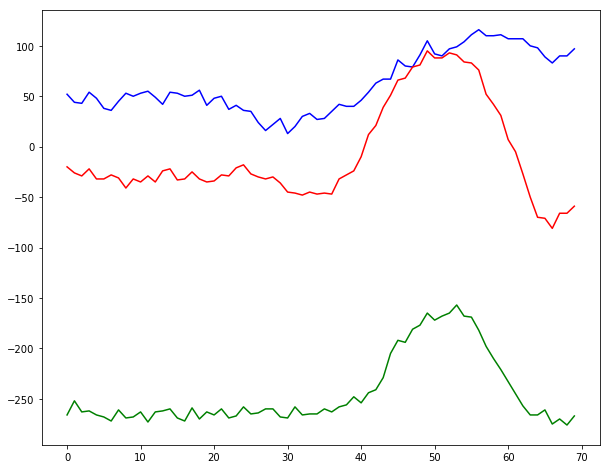

In [6]:
plt.plot([x[7] for x in data], color='b')
plt.plot([x[8] for x in data], color='r')
plt.plot([x[9] for x in data], color='g')
plt.show()

In [7]:
fusioner = fusion.Fusion()
dtime = 0.02
angles = []
for a in data:
    fusioner.update_nomag(dtime, (a[1], a[2], a[3]), (a[4], a[5], a[6]))
    #fusioner.update_nomag(a[0], (a[1], a[2], a[3]), filtered_g)
    angles.append([fusioner.pitch, fusioner.heading, fusioner.roll])
angles.pop(0)

[0.23688670852436083, 0.4211241316867304, -0.13252937561055797]

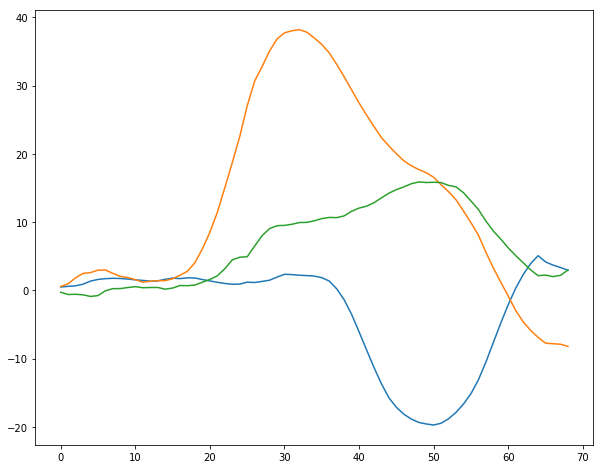

In [8]:
plt.plot([x[0] for x in angles])
plt.plot([x[1] for x in angles])
plt.plot([x[2] for x in angles])
plt.show()

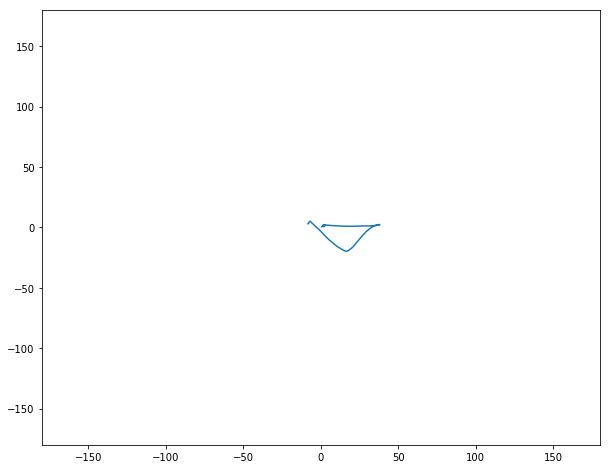

In [9]:
data_x = [x[1] for x in angles]
data_y = [x[0] for x in angles]
plt.plot([x[1] for x in angles], [x[0] for x in angles])
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.show()

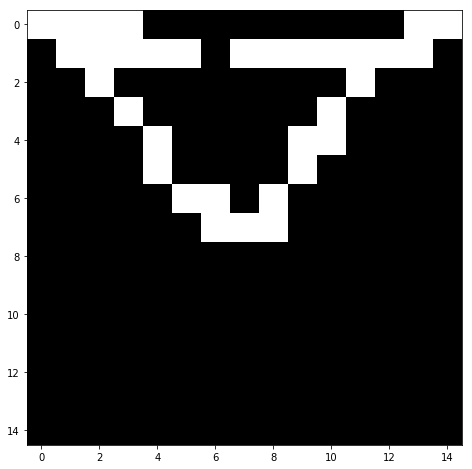

In [10]:
n = 15
max_x = max(data_x)
max_y = max(data_y)
min_x = min(data_x)
min_y = min(data_y)
delta = max(max_x - min_x, max_y - min_y) / (n - 1)
points = set()
for x, y in zip(data_x, data_y):
    points.add(((int((x - min_x) / delta)),(int((max_y - y) / delta))))


img = np.zeros([n, n])
for point in points:
    img[point[1], point[0]] = 1

plt.imshow(img, cmap='gray')
plt.show()

In [11]:
img_size = 15
num_labels = 6
n_layers = 10
type_name = {
    0: "circles",
    1: "vertical_lines",
    2: "horizontal_lines",
    3: "zeros",
    4: "up_triangles",
    5: "down_triangles"
}
data = np.ndarray([1, img_size * img_size]).astype(np.float32)
data[0, :] = (img - 0.5).reshape(img_size * img_size).astype(np.float32)

In [12]:
graph = tf.Graph()
with graph.as_default():
    weights_1 = tf.Variable(
        tf.truncated_normal([img_size * img_size, n_layers]), name="weights_1")
    weights_2 = tf.Variable(
        tf.truncated_normal([n_layers, num_labels]), name="weights_2")
    biases_1 = tf.Variable(tf.zeros([n_layers]), name="biases_1")
    biases_2 = tf.Variable(tf.zeros([num_labels]), name="biases_2")

    saver = tf.train.Saver()
    prediction = tf.nn.softmax(
        tf.matmul(tf.nn.relu(tf.matmul(data, weights_1) + biases_1), weights_2) + biases_2)

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    saver.restore(session, "tmp/model.ckpt")
    print("Model restored.")
    print('Initialized')
    print(prediction.eval())
    predict_index = np.argmax(prediction.eval(), 1)[0]
    print("Predict class type is " + type_name[predict_index])


INFO:tensorflow:Restoring parameters from tmp/model.ckpt
Model restored.
Initialized
[[  4.25701627e-11   5.31636790e-10   1.00000000e+00   4.50968637e-11
    1.27148830e-16   6.73836150e-17]]
Predict class type is horizontal_lines
